In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import os
import matplotlib.pyplot as plt
import re

In [38]:
folder_path = '../data/Traffic_data'

dataframes = {}

for file in os.listdir(folder_path):
    if file.endswith('.traffic.htm'):
        file_path = os.path.join(folder_path, file)
        file_name = file.split('.')[0]
        df_list = pd.read_html(file_path)
        df = df_list[4]
        df = df.iloc[1:].reset_index(drop=True)
        df_key = file_name
        dataframes[df_key] = df

In [39]:
# Create an empty list to store the modified DataFrames
modified_dfs = []

# Iterate through the dictionary and skip the first two rows of each DataFrame
for key, df in dataframes.items():
    modified_df = df.iloc[2:]  # Skip the first two rows
    modified_dfs.append(modified_df)

# Concatenate all the modified DataFrames into one big DataFrame
big_df = pd.concat(modified_dfs, ignore_index=True)

In [40]:
columns = df.iloc[1].tolist()
columns[5] = "LRP_2"
columns[6] = "Offset_2"
columns[7] = "Chainage_2"
columns[0] = 'Road'
columns[1] = 'Name'
big_df.columns = columns
big_df

,Road,Name,LRP,Offset,Chainage,LRP_2,Offset_2,Chainage_2,(Km),Heavy Truck,...,Car,Auto Rickshaw,Motor Cycle,Bi-Cycle,Cycle Rickshaw,Cart,Motorized,Non Motorized,Total AADT,(AADT)
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0,LRPS,822,0.822,0.822,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0,LRPS,822,0.822,0.822,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,2608.0,2508.0,436.0,213.0,1088.0,0.0,20236.0,1301.0,21537.0,21537.0
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,1851.0,2980.0,398.0,232.0,889.0,0.0,18236.0,1121.0,19357.0,19357.0
4,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,91.0,...,1690.0,2266.0,1087.0,75.0,1198.0,0.0,16288.0,1273.0,17561.0,17561.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,Z8915-3,Int.with Z8916 - Daulatkhan,LRP010,1150,10.47,LRP014,2290,15.66,5.190,0.0,...,25.0,1025.0,872.0,396.0,380.0,0.0,2341.0,776.0,3117.0,3117.0
2062,Z8916-1,Guingerhat (Int.with R890) - Int.with Z8915,LRPS,0,0,LRP004,3626,7.626,7.626,0.0,...,15.0,672.0,640.0,453.0,524.0,0.0,1463.0,977.0,2440.0,2440.0
2063,Z8916-2,Int.with Z8915 - Daulatkhan Bazar,LRP004,3626,7.626,LRP005,6600,11.591,3.965,0.0,...,15.0,672.0,640.0,453.0,524.0,0.0,1463.0,977.0,2440.0,2440.0
2064,Z8943-1,Tazumuddin (Int.with Z8905) - Fakirhat (Int.wi...,LRPS,0,0,LRPS,6446,6.446,6.446,0.0,...,42.0,912.0,679.0,528.0,584.0,0.0,1971.0,1112.0,3083.0,3083.0


In [41]:
big_df['type'] = 'road'
# Define a function to find all road names in the 'Name' column
def find_roads(name):
    # Regular expression to match the pattern described (roads starting with Z, N, or R followed by numbers)
    road_pattern = re.compile(r'\b[ZNR]\d+\b')
    # Find all matches in the name
    found_roads = road_pattern.findall(name)
    return found_roads

# Apply the function to the 'Name' column to create a new column with the list of identified roads
big_df['identified_roads'] = big_df['Name'].apply(find_roads)


In [42]:
bmms = pd.read_excel("../data/BMMS_overview.xlsx")

In [43]:
bmms

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.800,19.5,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.698739,90.458861,interpolate
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.4,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.694664,90.487775,interpolate
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.705060,90.523214,interpolate
3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.30,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.880,12.2,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694391,90.537574,interpolate
4,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.30,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,12.2,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.694302,90.537707,interpolate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20410,Z8806,83.728,Box Culvert,LRP083a,.,1.78,D,110470,Lebukhali-Dumki-Boga-Bauphal-Kalaiya-Dashmina-...,83.728,7.6,1980.0,1.0,Barisal,Patuakhali,Barguna,Barguna,22.183448,90.299962,interpolate
20411,Z8810,3.981,Steel Beam & RCC Slab,LRP003b,.,27.20,D,113458,Bakerganj-Padrishibpur-Kathaltali-Subidkhali-B...,3.981,3.2,1979.0,5.0,Barisal,Barisal,Barisal,Barisal-1,22.519353,90.310063,interpolate
20412,Z8814,20.730,Baily with Steel Deck,LRP020b,Kalbari Bridge,30.50,D,121147,Barguna (Dakhin Ramna Kheya Ghat)-Dewatala-Mat...,20.730,NaN,NaN,NaN,Barisal,Barisal,Pirojpur,Kawkhali,22.282704,89.968512,interpolate
20413,Z8910,28.880,RCC Girder Bridge,LRP028a,Narainpur Bridge,9.50,D,119249,Barisal (Bairagirpool)-Tumchar-Bauphaul Road,28.880,NaN,NaN,NaN,Barisal,Patuakhali,Patuakhali,Patuakhali,22.510650,90.535314,interpolate


In [44]:
big_df['base_road'] = big_df['Road'].apply(lambda x: x.split('-')[0])
big_df['Chainage'] = pd.to_numeric(big_df['Chainage'], errors='coerce')
bmms['chainage'] = pd.to_numeric(bmms['chainage'], errors='coerce')

# Step 1: Select and possibly rename columns from bmms_df
# Assuming 'road', 'chainage', 'name', 'condition' are the columns you want from bmms_df
# and that you've already created a column in traffic_df to accommodate 'condition' data
bmms_subset = bmms[['road', 'chainage', 'name', 'condition', 'lat', 'lon']].copy()
bmms_subset.rename(columns={'road': 'base_road', 'chainage': 'Chainage', 'name': 'Name'}, inplace=True)

# Optionally add any missing columns to bmms_subset with default values or NaN
# For columns in big_df that don't have a counterpart in bmms_subset
for col in big_df.columns:
    if col not in bmms_subset.columns:
        bmms_subset[col] = pd.NA
bmms_subset['type'] = 'bridge'

# Step 2: Use pd.concat to append bmms_subset as new rows to big_df
# Note: Ensure the columns match or have been appropriately accounted for before concatenating
combined_df = pd.concat([big_df, bmms_subset], ignore_index=True)

# Now 'combined_df' contains the original rows from 'traffic_df' and new rows from 'bmms_subset'
combined_df


,Road,Name,LRP,Offset,Chainage,LRP_2,Offset_2,Chainage_2,(Km),Heavy Truck,...,Motorized,Non Motorized,Total AADT,(AADT),type,identified_roads,base_road,condition,lat,lon
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0.000,LRPS,822,0.822,0.822,402.0,...,18236.0,1121.0,19357.0,19357.0,road,[Z1101],N1,NaN,NaN,NaN
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0.000,LRPS,822,0.822,0.822,660.0,...,20236.0,1301.0,21537.0,21537.0,road,[Z1101],N1,NaN,NaN,NaN
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,20236.0,1301.0,21537.0,21537.0,road,"[Z1101, R111]",N1,NaN,NaN,NaN
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,18236.0,1121.0,19357.0,19357.0,road,"[Z1101, R111]",N1,NaN,NaN,NaN
4,N1-3L,Signboard - Shimrail (Left)R110 (Left),LRPS,4175,4.175,LRPS,7181,7.181,3.006,91.0,...,16288.0,1273.0,17561.0,17561.0,road,[R110],N1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476,NaN,.,NaN,NaN,83.728,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8806,D,22.183448,90.299962
22477,NaN,.,NaN,NaN,3.981,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8810,D,22.519353,90.310063
22478,NaN,Kalbari Bridge,NaN,NaN,20.730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8814,D,22.282704,89.968512
22479,NaN,Narainpur Bridge,NaN,NaN,28.880,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8910,D,22.510650,90.535314


In [45]:
combined_df = combined_df.sort_values(by=['base_road', 'Chainage'])
combined_df.reset_index(drop=True, inplace=True)

In [46]:
combined_df

,Road,Name,LRP,Offset,Chainage,LRP_2,Offset_2,Chainage_2,(Km),Heavy Truck,...,Motorized,Non Motorized,Total AADT,(AADT),type,identified_roads,base_road,condition,lat,lon
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0.000,LRPS,822,0.822,0.822,402.0,...,18236.0,1121.0,19357.0,19357.0,road,[Z1101],N1,NaN,NaN,NaN
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0.000,LRPS,822,0.822,0.822,660.0,...,20236.0,1301.0,21537.0,21537.0,road,[Z1101],N1,NaN,NaN,NaN
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,20236.0,1301.0,21537.0,21537.0,road,"[Z1101, R111]",N1,NaN,NaN,NaN
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,18236.0,1121.0,19357.0,19357.0,road,"[Z1101, R111]",N1,NaN,NaN,NaN
4,NaN,.,NaN,NaN,1.800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,N1,A,23.698739,90.458861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476,Z8943-2,Fakirhat (Int.with Z8948) - Kungerhat (Int.wit...,LRPS,6446,6.446,LRPS,8800,8.8,2.354,0.0,...,1971.0,1112.0,3083.0,3083.0,road,"[Z8948, R890]",Z8943,NaN,NaN,NaN
22477,NaN,NaN,NaN,NaN,6.692,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8943,A,22.428621,90.788543
22478,NaN,.,NaN,NaN,6.767,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8943,A,22.428872,90.787904
22479,NaN,NaN,NaN,NaN,8.104,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8943,C,22.430219,90.775203


In [47]:
roads = pd.read_csv('../../EPA133a-G2-A3/data/_roads3.csv')
roads

,road,chainage,lrp,lat,lon,gap,type,name
0,N1,0.000,LRPS,23.706028,90.443333,NaN,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,NaN,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,NaN,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,NaN,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,NaN,KmPost,Km post missing
...,...,...,...,...,...,...,...,...
51343,Z8943,7.000,LRP007,22.429499,90.785722,NaN,KmPost,Km Post Missing
51344,Z8943,8.000,LRP008,22.430110,90.776333,NaN,KmPost,Km Post Missing
51345,Z8943,8.133,LRP008a,22.430249,90.774888,BS,Bridge,Start of Bridge
51346,Z8943,8.151,LRP008b,22.430249,90.774860,BE,Bridge,End of Bridge


In [48]:
for index, row in combined_df.iterrows():
    if pd.isnull(row['lat']):
        chainage = row['Chainage']
        road = row['base_road']
        closest_chainage = 9999
        closest_lat = 99999
        closest_lon = 99999
        closest_row = None
        for index2, row2 in roads[roads['road'] == road].iterrows():
            if abs(chainage - row2['chainage']) < closest_chainage:
                closest_row = row2
                closest_lat = row2['lat']
                closest_lon = row2['lon']
                closest_chainage = abs(chainage - row2['chainage'])
            else:
                combined_df.loc[index, 'lat'] = closest_lat
                combined_df.loc[index, 'lon'] = closest_lon
                break
        
                
            
            
        

In [49]:
combined_df.to_csv('../data/traffic_df_with_bridges.csv', index=False)

In [50]:
df = combined_df.copy()
df

,Road,Name,LRP,Offset,Chainage,LRP_2,Offset_2,Chainage_2,(Km),Heavy Truck,...,Motorized,Non Motorized,Total AADT,(AADT),type,identified_roads,base_road,condition,lat,lon
0,N1-1L,Jatrabari - Int.with Z1101 (Left) (Left),LRPS,0,0.000,LRPS,822,0.822,0.822,402.0,...,18236.0,1121.0,19357.0,19357.0,road,[Z1101],N1,NaN,23.706028,90.443333
1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0.000,LRPS,822,0.822,0.822,660.0,...,20236.0,1301.0,21537.0,21537.0,road,[Z1101],N1,NaN,23.706028,90.443333
2,N1-2L,Int.with Z1101 - Signboard (Left) R111 (Left),LRPS,822,0.822,LRPS,4175,4.175,3.353,660.0,...,20236.0,1301.0,21537.0,21537.0,road,"[Z1101, R111]",N1,NaN,23.702778,90.450472
3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,402.0,...,18236.0,1121.0,19357.0,19357.0,road,"[Z1101, R111]",N1,NaN,23.702778,90.450472
4,NaN,.,NaN,NaN,1.800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,N1,A,23.698739,90.458861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22476,Z8943-2,Fakirhat (Int.with Z8948) - Kungerhat (Int.wit...,LRPS,6446,6.446,LRPS,8800,8.8,2.354,0.0,...,1971.0,1112.0,3083.0,3083.0,road,"[Z8948, R890]",Z8943,NaN,22.428666,90.788416
22477,NaN,NaN,NaN,NaN,6.692,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8943,A,22.428621,90.788543
22478,NaN,.,NaN,NaN,6.767,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8943,A,22.428872,90.787904
22479,NaN,NaN,NaN,NaN,8.104,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,bridge,NaN,Z8943,C,22.430219,90.775203


In [51]:
df_filtered = df[~df["Road"].str.contains("L", na=False)]
df_filtered.to_csv('../data/traffic_df_with_bridges_and_intersections_onlyR.csv')

In [52]:
df_filtered = df_filtered.reset_index()

In [53]:
# Convert columns to numeric, coercing any errors to NaN
df_filtered['Heavy Truck'] = pd.to_numeric(df_filtered['Heavy Truck'], errors='coerce')
df_filtered['Medium Truck'] = pd.to_numeric(df_filtered['Medium Truck'], errors='coerce')
df_filtered['Small Truck'] = pd.to_numeric(df_filtered['Small Truck'], errors='coerce')
df_filtered['Utility'] = pd.to_numeric(df_filtered['Utility'], errors='coerce')

# Perform the calculation
df_filtered['cargo_weight'] = (df_filtered['Heavy Truck'] * 40.8 +
                               df_filtered['Medium Truck'] * 10 +
                               df_filtered['Small Truck'] * 1.5 +
                               df_filtered['Utility'] * 0.97)

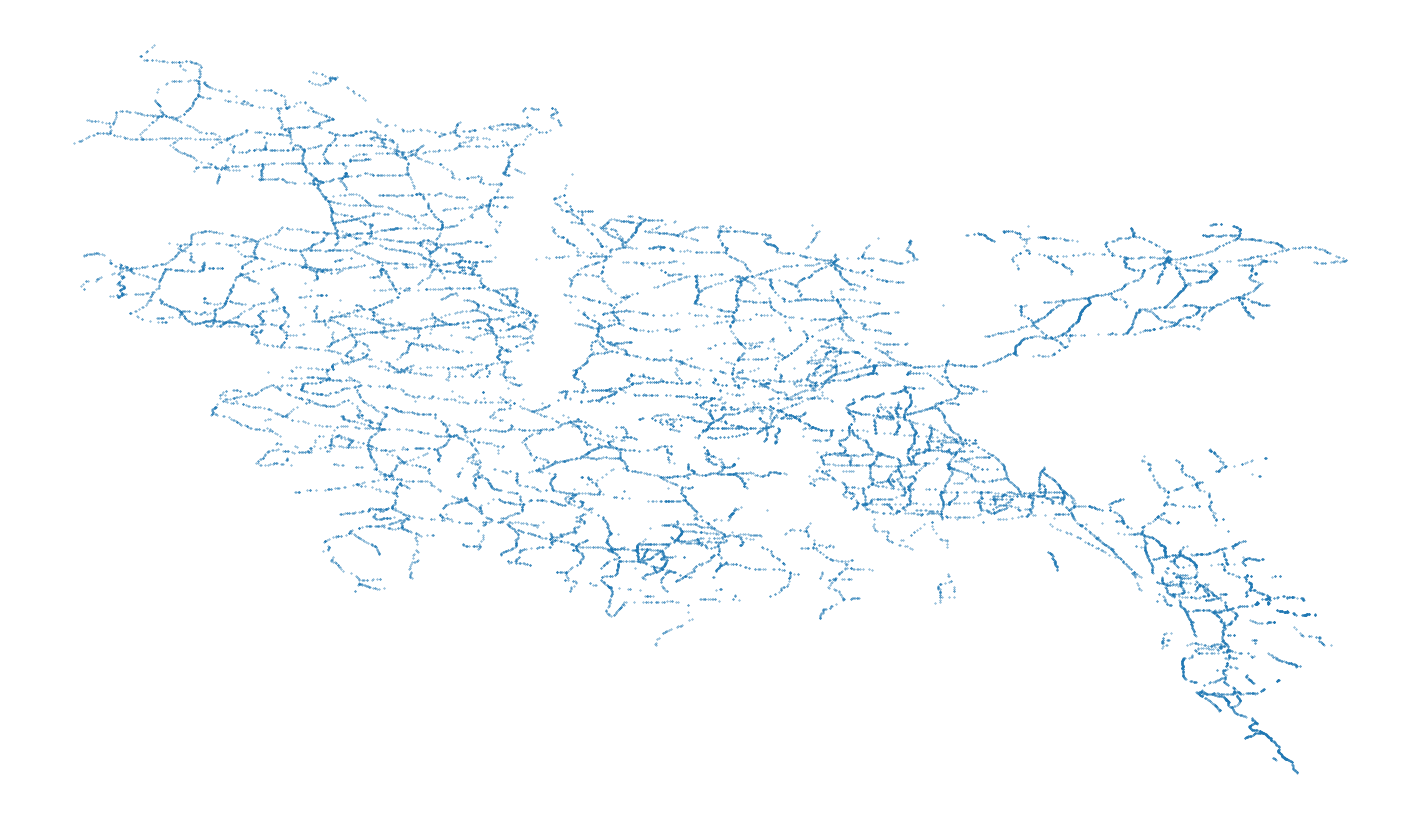

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming combined_df is your DataFrame and it has 'lat' and 'lon' columns
positions = {index: (
    row['lon'], row['lat'], row['Name'], row['Road'], row['base_road'],
    row['Heavy Truck'], row['Medium Truck'], row['Small Truck'],
    row['Large Bus'], row['Medium Bus'], row['Micro Bus'], row['Utility'],
    row['Car'], row['Auto Rickshaw'], row['Motor Cycle'], row['Bi-Cycle'],
    row['Cycle Rickshaw'], row['Cart'], row['Motorized'], row['Non Motorized'],
    row['Total AADT'], row['(AADT)']
) for index, row in df_filtered.iterrows()}

# Create a graph
G = nx.Graph()

# Add nodes with positions
for node, pos in positions.items():
    G.add_node(node,
               pos=(pos[0], pos[1]),
               Name=pos[2],
               Road=pos[3],
               base_road=pos[4],
               Heavy_Truck=pos[5],
               Medium_Truck=pos[6],
               Small_Truck=pos[7],
               Large_Bus=pos[8],
               Medium_Bus=pos[9],
               Micro_Bus=pos[10],
               Utility=pos[11],
               Car=pos[12],
               Auto_Rickshaw=pos[13],
               Motor_Cycle=pos[14],
               Bi_Cycle=pos[15],
               Cycle_Rickshaw=pos[16],
               Cart=pos[17],
               Motorized=pos[18],
               Non_Motorized=pos[19],
               Total_AADT=pos[20],
               AADT=pos[21])  # Assuming 'AADT' is at pos[21], adjust accordingly


# If you also want to connect nodes, you can add edges here
# For example, to connect each node to its nearest neighbor (simplistic approach):
# for i, node_i_pos in positions.items():
#     closest_node, min_dist = None, float('inf')
#     for j, node_j_pos in positions.items():
#         if i != j:
#             dist = ((node_i_pos[0] - node_j_pos[0])**2 + (node_i_pos[1] - node_j_pos[1])**2)**0.5
#             if dist < min_dist:
#                 closest_node, min_dist = j, dist
#     G.add_edge(i, closest_node)

# Extract positions from graph nodes for plotting
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(14, 8))
# Draw the graph
nx.draw(G, pos, node_size=0.1)  # Adjust node_size for better visibility
plt.show()


In [55]:
previous_node = None
previous_base_road = None

for index, row in df_filtered.iterrows():
    current_base_road = row['base_road']
  
    if previous_node is not None and previous_base_road == current_base_road:
        G.add_edge(previous_node, index)
    
    previous_node = index
    previous_base_road = current_base_road

In [56]:
for index, row in df_filtered.iterrows():
    row_lat = row['lat']
    row_lon = row['lon']
    best_abs = 9999
    best_row = None
    # Check if the value is not NaN and is an instance of list
    if isinstance(row['identified_roads'], list):
        for road in row['identified_roads']:
            for index2, row2 in df_filtered[df_filtered['base_road'] == road].iterrows():
                diff_lat = abs(row2['lat'] - row_lat)
                diff_lon = abs(row2['lon'] - row_lon)
                diff_abs = diff_lon + diff_lat
                if diff_abs < best_abs:
                    best_abs = diff_abs
                    best_row = row2
    if best_row is not None:
        G.add_edge(best_row.name, row.name, weight=0)
                
                

In [57]:
# Iterate through each node and its attributes
for node, attrs in G.nodes(data=True):
    for key, value in attrs.items():
        # Check if the attribute value is 'NS' or NaN (pd.isna() checks for NaN)
        if value == 'NS' or pd.isna(value):
            # Update the attribute value to 0
            attrs[key] = 0

# Now, all 'NS' and NaN values in node attributes are replaced with 0

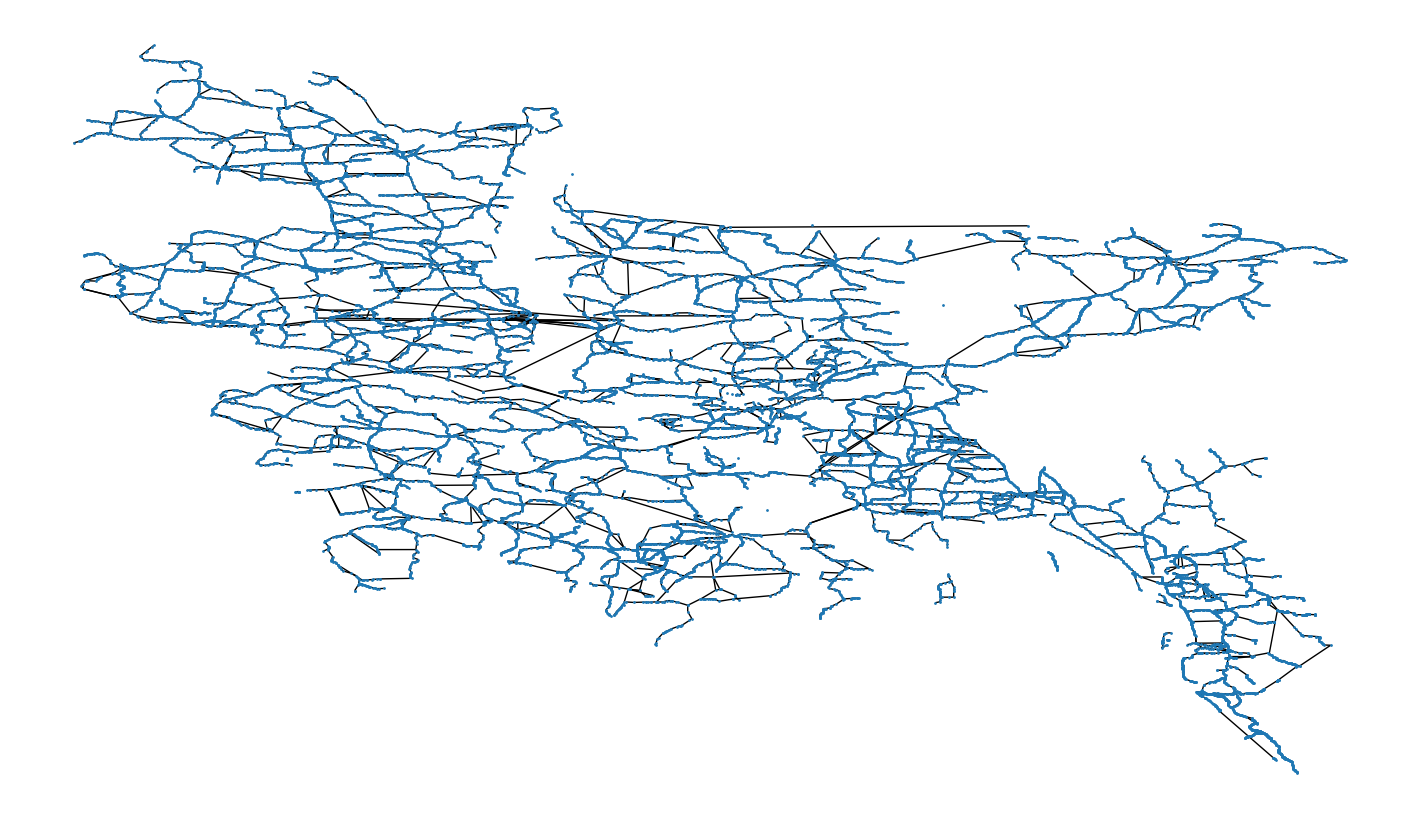

In [58]:
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(14, 8))
# Draw the graph
nx.draw(G, pos, node_size=1)  # Adjust node_size for better visibility
plt.show()

In [22]:
# def road_in_graph(graph, road_name):
#     for node in graph.nodes(data=True):
#         if node[1].get('Road') == road_name:
#             return True
#     return False
# 
# def find_potential_edges(road):
#     edges = []
#     base, part = road.rsplit('-', 1)
#     
#     if part.endswith('L'):
#         # Add edges to the next road number on the left side and to the generic road
#         edges.append((road, f"{base}-{str(int(part[:-1])+1)}L"))
#         edges.append((road, f"{base}-{str(int(part[:-1])+1)}"))
#     elif part.endswith('R'):
#         # Add edges to the next road number on the right side (We don't connect R to the generic road as per the rule)
#         edges.append((road, f"{base}-{str(int(part[:-1])+1)}R"))
#     else:
#         # This case handles roads without L or R and tries to increment
#         try:
#             numeric_part = int(part)
#             # Add edges to both L and R of the next road number and to the next generic road
#             edges.append((road, f"{base}-{str(numeric_part+1)}L"))
#             edges.append((road, f"{base}-{str(numeric_part+1)}R"))
#             edges.append((road, f"{base}-{str(numeric_part+1)}"))
#         except ValueError:
#             # In case the part is not numeric, we won't add any edges
#             pass
#     
#     return edges
# 
# # For each road, find and add potential edges
# for road in G.nodes():
#     name_attribute = G.nodes[road].get('Road')
#     if pd.isnull(name_attribute) == False:
#         potential_edges = find_potential_edges(name_attribute)
#         for edge in potential_edges:
#             # print('road', G.nodes[road].get('Road'))
#             # print(potential_edges)
#             if edge[1] in G.nodes():  # Add the edge only if the target node exists
#                 print(edge)
#                 G.add_edge(*edge, color='red')
# 
# # Show a brief summary of the graph to confirm edge creation

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

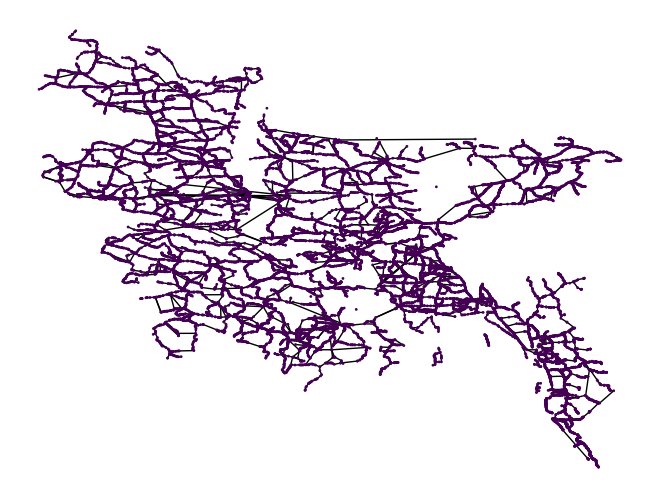

In [59]:


# Assuming G is your NetworkX graph

# First, clean the 'Motorized' attribute
for node, attrs in G.nodes(data=True):
    motorized_value = attrs.get('cargo_weight', 'NS')  # Default 'NS' if 'Motorized' is missing
    if motorized_value == 'NS' or pd.isna(motorized_value):
        attrs['cargo_weight'] = 0
    else:
        # Ensure the value is numeric (convert if necessary)
        attrs['cargo_weight'] = pd.to_numeric(motorized_value, errors='coerce')
        if pd.isna(attrs['cargo_weight']):
            # In case conversion fails, set to 0
            attrs['cargo_weight'] = 0

# Extract the 'Motorized' attribute again, now that it's cleaned
motorized_values = np.array([data['cargo_weight'] for _, data in G.nodes(data=True)])

# Normalize 'Motorized' values for color mapping
norm = plt.Normalize(vmin=motorized_values.min(), vmax=motorized_values.max())
colors = plt.cm.viridis(norm(motorized_values))

# Draw the network with node colors based on 'Motorized'
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G,pos, node_color=colors, with_labels=False, node_size=1)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), label='cargo_weight')
plt.title('Network Graph Colored by Motorized Attribute')
plt.show()


In [33]:
# Convert columns to numeric, coercing any errors to NaN
df_filtered['Heavy Truck'] = pd.to_numeric(df_filtered['Heavy Truck'], errors='coerce')
df_filtered['Medium Truck'] = pd.to_numeric(df_filtered['Medium Truck'], errors='coerce')
df_filtered['Small Truck'] = pd.to_numeric(df_filtered['Small Truck'], errors='coerce')
df_filtered['Utility'] = pd.to_numeric(df_filtered['Utility'], errors='coerce')

# Perform the calculation
df_filtered['cargo_weight'] = (df_filtered['Heavy Truck'] * 40.8 +
                               df_filtered['Medium Truck'] * 10 +
                               df_filtered['Small Truck'] * 1.5 +
                               df_filtered['Utility'] * 0.97)

In [34]:
df_filtered

,index,Road,Name,LRP,Offset,Chainage,LRP_2,Offset_2,Chainage_2,(Km),...,Non Motorized,Total AADT,(AADT),type,identified_roads,base_road,condition,lat,lon,cargo_weight
0,1,N1-1R,Jatrabari - Int.with Z1101 (Left) (Right),LRPS,0,0.000,LRPS,822,0.822,0.822,...,1301.0,21537.0,21537.0,road,[Z1101],N1,NaN,23.706028,90.443333,91274.60
1,3,N1-2R,Int.with Z1101 - Signboard (Left) R111 (Right),LRPS,822,0.822,LRPS,4175,4.175,3.353,...,1121.0,19357.0,19357.0,road,"[Z1101, R111]",N1,NaN,23.702778,90.450472,76772.96
2,4,NaN,.,NaN,NaN,1.800,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,bridge,NaN,N1,A,23.698739,90.458861,NaN
3,6,N1-3R,Signboard - Shimrail (Left)R110 (Right),LRPS,4175,4.175,LRPS,7181,7.181,3.006,...,1212.0,16657.0,16657.0,road,[R110],N1,NaN,23.693805,90.480527,32276.56
4,7,NaN,.,NaN,NaN,4.925,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,bridge,NaN,N1,A,23.694664,90.487775,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22404,22476,Z8943-2,Fakirhat (Int.with Z8948) - Kungerhat (Int.wit...,LRPS,6446,6.446,LRPS,8800,8.8,2.354,...,1112.0,3083.0,3083.0,road,"[Z8948, R890]",Z8943,NaN,22.428666,90.788416,1201.83
22405,22477,NaN,NaN,NaN,NaN,6.692,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,bridge,NaN,Z8943,A,22.428621,90.788543,NaN
22406,22478,NaN,.,NaN,NaN,6.767,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,bridge,NaN,Z8943,A,22.428872,90.787904,NaN
22407,22479,NaN,NaN,NaN,NaN,8.104,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,bridge,NaN,Z8943,C,22.430219,90.775203,NaN


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

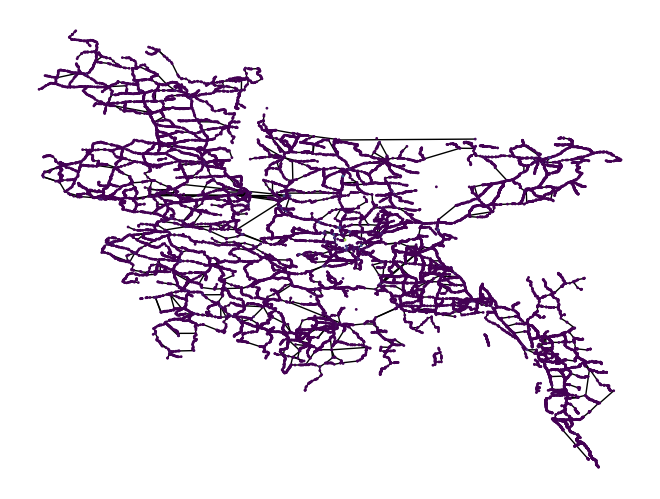

In [37]:
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=1)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), label='Motorized')
plt.title('Network Graph Colored by Motorized Attribute')
plt.show()